##### Copyright 2022 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Retrain a speech recognition model with TensorFlow Lite Model Maker


### Import the required packages


You'll need TensorFlow, TFLite Model Maker, and some modules for audio manipulation, playback, and visualizations.

In [ ]:
#!sudo apt -y install libportaudio2
#!pip install tflite-model-maker

In [1]:
import os
import glob
import random
import shutil

import librosa
import soundfile as sf
from IPython.display import Audio
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tflite_model_maker as mm
from tflite_model_maker import audio_classifier
from tflite_model_maker.config import ExportFormat
from timeit import default_timer as timer

print(f"TensorFlow Version: {tf.__version__}")
print(f"Model Maker Version: {mm.__version__}")
!python --version

c:\Users\Mu_keeS\#speech_V4\.mu_envlite3.8\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.9.0 and strictly below 2.12.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.5.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


TensorFlow Version: 2.5.0
Model Maker Version: 0.3.2
Python 3.8.10


## Prepare the dataset

In [2]:
use_custom_dataset = True #False #@param ["False", "True"] {type:"raw"}

### Generate a background noise dataset

### Prepare the speech commands dataset

### Prepare a custom dataset

In [3]:
if use_custom_dataset:
  # Specify the ZIP file you uploaded:
  ############3!unzip YOUR-FILENAME.zip
  # Specify the unzipped path to your custom dataset
  # (this path contains all the subfolders with classification names):
  
  dataset_dir = '../data-V-af-Splitted/Train_MM/' #Model_maker/data-V-ModelMaker/Train_MM/' #Main_sp/data-V'#Af-V-data/afaraf600-DS'#YOUR-DIRNAME'
  
  #dataset_dir= '../data_V/data-set-1015'#C:\\Users\\Mu_keeS\\speech_rec_V3\\amharic\\data\\data-set-1015'
  

After changing the filename and path name above, you're ready to train the model with your custom dataset. In the Colab toolbar, select **Runtime > Run all** to run the whole notebook.

The following code integrates our new background noise samples into your dataset and then separates a portion of all samples to create a test set.

In [4]:
def move_background_dataset(dataset_dir):
  dest_dir = os.path.join(dataset_dir, 'background')
  if os.path.exists(dest_dir):
    files = glob.glob(os.path.join(background_dir, '*.wav'))
    for file in files:
      shutil.move(file, dest_dir)
  else:
    shutil.move(background_dir, dest_dir)

In [4]:
val_dir = '../data-V-af-Splitted/Val_MM/'#Model_maker/data-V-ModelMaker/Val_MM/'#C:\Users\Mu_keeS\#speech_V4\Main_sp\data-V-af-Splitted
test_dir = '../data-V-af-Splitted/Test_MM/'#Model_maker/data-V-ModelMaker/Test_MM/'

### Play a sample

To be sure the dataset looks correct, let's play at a random sample from the test set:

In [5]:
def get_random_audio_file(samples_dir):
  files = os.path.abspath(os.path.join(samples_dir, '*/*.wav'))
  files_list = glob.glob(files)
  random_audio_path = random.choice(files_list)
  return random_audio_path

def show_sample(audio_path):
  audio_data, sample_rate = sf.read(audio_path)
  class_name = os.path.basename(os.path.dirname(audio_path))
  print(f'Class: {class_name}')
  print(f'File: {audio_path}')
  print(f'Sample rate: {sample_rate}')
  print(f'Sample length: {len(audio_data)}')

  plt.title(class_name)
  plt.plot(audio_data)
  display(Audio(audio_data, rate=sample_rate))

Class: Unknown
File: c:\Users\Mu_keeS\#speech_V4\Main_sp\data-V-af-Splitted\Test_MM\Unknown\5aac2efa_nohash_1.wav
Sample rate: 16000
Sample length: 16000


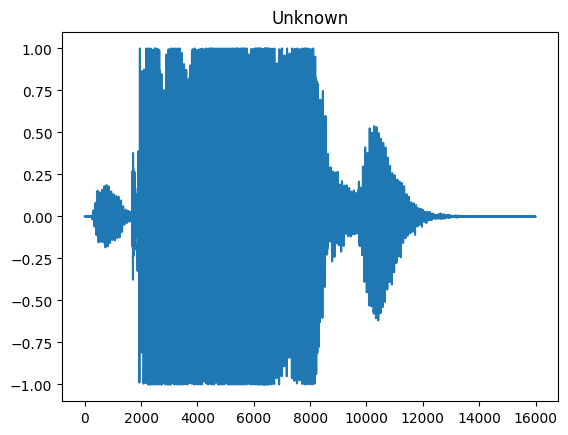

In [6]:
random_audio = get_random_audio_file(test_dir)
show_sample(random_audio)

## Define the model


When using Model Maker to retrain any model, you have to start by defining a model spec. The spec defines the base model from which your new model will extract feature embeddings to begin learning new classes. The spec for this speech recognizer is based on the pre-trained [BrowserFft model from TFJS](https://github.com/tensorflow/tfjs-models/tree/master/speech-commands#speech-command-recognizer).

The model expects input as an audio sample that's 43.1 kHz, and just under a second long: the exact sample length must be 44034 frames.


In [7]:

spec = audio_classifier.BrowserFftSpec()
#sample_rate=41000
#audio_data,_ = librosa.load(random_audio, sr= sample_rate)

INFO:tensorflow:Checkpoints are stored in C:\Users\Mu_keeS\AppData\Local\Temp\tmp1_ya5luj


## Load your dataset 

#### Load a custom dataset

**Note:** Setting `cache=True` is important to make training faster (especially when the dataset must be re-sampled) but it will also require more RAM to hold the data. If you use a very large custom dataset, caching might exceed your RAM capacity.

In [8]:
#val_dir = '../Model_maker/data-V-ModelMaker/Val_MM/'
#test_dir = '../Model_maker/data-V-ModelMaker/Test_MM/'
#val_dir= '../Model_maker/data-V-ModelMaker/Val_MM/'

if use_custom_dataset:
    ## EDit to uppload Validation dta from folder
    #train_data_ratio = 0.8
    train_data = audio_classifier.DataLoader.from_folder(
    spec, dataset_dir, cache=True)
    #train_data, validation_data = train_data.split(train_data_ratio)

    validation_data = audio_classifier.DataLoader.from_folder(
        spec, val_dir, cache=True)
    test_data = audio_classifier.DataLoader.from_folder(
        spec, test_dir, cache=True)


## Train the model


Now we'll use the Model Maker [`create()`](https://www.tensorflow.org/lite/api_docs/python/tflite_model_maker/audio_classifier/create) function to create a model based on our model spec and training dataset, and begin training.

If you're using a custom dataset, you might want to change the batch size as appropriate for the number of samples in your train set.

**Note:** The first epoch takes longer because it must create the cache. 

In [ ]:
# If your dataset has fewer than 100 samples per class,
# you might want to try a smaller batch size

In [9]:
# If the dataset has fewer than 100 samples per class,
# a smaller batch size is recommended
batch_size = 25
epochs = 25
model = audio_classifier.create(train_data, spec, validation_data, batch_size, epochs)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 42, 225, 8)        136       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 21, 112, 8)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 109, 32)       2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 54, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 51, 32)         8224      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 25, 32)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 22, 32)        

## Review the model performance

Even if the accuracy/loss looks good from the training output above, it's important to also run the model using test data that the model has not seen yet, which is what the `evaluate()` method does here:

In [10]:
ll= []
ll= model.evaluate(test_data)
print(f'Accuracy= {ll[1]}')
print(f'Loss= {ll[0]}')

28/28 [==============================] - 47s 2s/step - loss: 0.0268 - acc: 0.9944
Accuracy= 0.994369387626648
Loss= 0.02682187594473362


### View the confusion matrix

When training a classification model such as this one, it's also useful to inspect the [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix). The confusion matrix gives you detailed visual representation of how well your classifier performs for each classification in your test data.

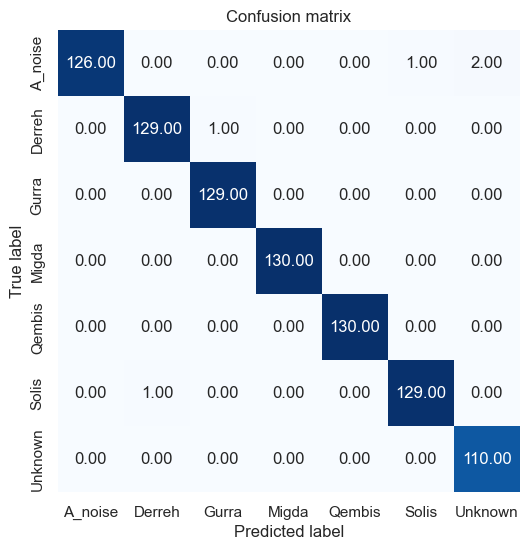

In [11]:
def show_confusion_matrix(confusion, test_labels):
  """Compute confusion matrix and normalize."""
  confusion_normalized = confusion.astype('int')# / confusion.sum(axis=1)
  sns.set(rc = {'figure.figsize':(6,6)})
  sns.heatmap(
      confusion_normalized, xticklabels=test_labels, yticklabels=test_labels,
      cmap='Blues', annot=True, fmt='.2f', square=True, cbar=False)
  plt.title("Confusion matrix")
  plt.ylabel("True label")
  plt.xlabel("Predicted label")

confusion_matrix = model.confusion_matrix(test_data)
show_confusion_matrix(confusion_matrix.numpy(), test_data.index_to_label)

## Export the model

The last step is exporting your model into the TensorFlow Lite format for execution on mobile/embedded devices and into the [SavedModel format](https://www.tensorflow.org/guide/saved_model) for execution elsewhere.

When exporting a `.tflite` file from Model Maker, it includes [model metadata](https://www.tensorflow.org/lite/inference_with_metadata/overview) that describes various details that can later help during inference. It even includes a copy of the classification labels file, so you don't need to a separate `labels.txt` file. (In the next section, we show how to use this metadata to run an inference.)

In [12]:
TFLITE_FILENAME = 'QafarAf-Model1.tflite'
SAVE_PATH = './models-v89'

print(f'Exporing the model to {SAVE_PATH}')
model.export(SAVE_PATH, tflite_filename=TFLITE_FILENAME)
model.export(SAVE_PATH, export_format=[mm.ExportFormat.SAVED_MODEL, mm.ExportFormat.LABEL])

Exporing the model to ./models-v89


INFO:tensorflow:Assets written to: C:\Users\Mu_keeS\AppData\Local\Temp\tmpwl8lkkzn\assets
INFO:tensorflow:TensorFlow Lite model exported successfully: ./models-v89\QafarAf-Model1.tflite


INFO:tensorflow:TensorFlow Lite model exported successfully: ./models-v89\QafarAf-Model1.tflite


INFO:tensorflow:Assets written to: ./models-v89\saved_model\assets


INFO:tensorflow:Assets written to: ./models-v89\saved_model\assets


INFO:tensorflow:Saving labels in ./models-v89\labels.txt


INFO:tensorflow:Saving labels in ./models-v89\labels.txt


## Run inference with TF Lite model

Now your TFLite model can be deployed and run using any of the supported [inferencing libraries](https://www.tensorflow.org/lite/guide/inference) or with the new [TFLite AudioClassifier Task API](https://www.tensorflow.org/lite/inference_with_metadata/task_library/audio_classifier). The following code shows how you can run inference with the `.tflite` model in Python.

In [ ]:
# This library provides the TFLite metadata API
#! pip install -q tflite_support

In [14]:
from tflite_support import metadata
import json

def get_labels(model):
  """Returns a list of labels, extracted from the model metadata."""
  displayer = metadata.MetadataDisplayer.with_model_file(model)
  labels_file = displayer.get_packed_associated_file_list()[0]
  labels = displayer.get_associated_file_buffer(labels_file).decode()
  return [line for line in labels.split('\n')]

def get_input_sample_rate(model):
  """Returns the model's expected sample rate, from the model metadata."""
  displayer = metadata.MetadataDisplayer.with_model_file(model)
  metadata_json = json.loads(displayer.get_metadata_json())
  input_tensor_metadata = metadata_json['subgraph_metadata'][0][
          'input_tensor_metadata'][0]
  input_content_props = input_tensor_metadata['content']['content_properties']
  return input_content_props['sample_rate']


---prediction---
Class: A_noise
Score: 0.8580951690673828
----truth----
Class: A_noise
File: c:\Users\Mu_keeS\#speech_V4\Main_sp\data-V-af-Splitted\Test_MM\A_noise\_noise.340.wav
Sample rate: 16000
Sample length: 16000


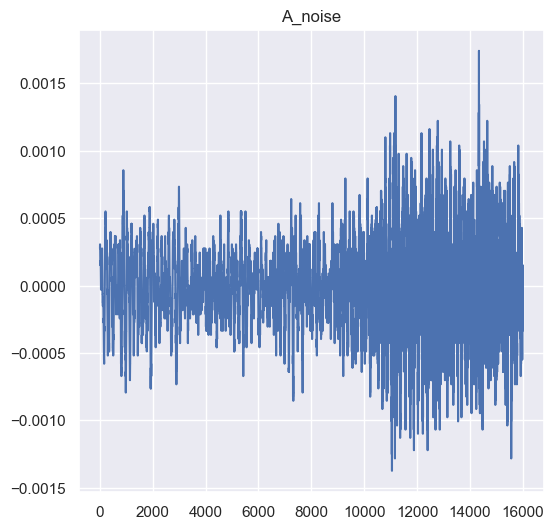

In [34]:
# Get a WAV file for inference and list of labels from the model
tflite_file = os.path.join(SAVE_PATH, TFLITE_FILENAME)
labels = get_labels(tflite_file)
random_audio = get_random_audio_file(test_dir)

# Ensure the audio sample fits the model input
interpreter = tf.lite.Interpreter(tflite_file)
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
input_size = input_details[0]['shape'][1]
sample_rate = get_input_sample_rate(tflite_file)
audio_data, _ = librosa.load(random_audio, sr=sample_rate)
if len(audio_data) < input_size:
  audio_data.resize(input_size)
audio_data = np.expand_dims(audio_data[:input_size], axis=0)

# Run inference
interpreter.allocate_tensors()
interpreter.set_tensor(input_details[0]['index'], audio_data)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])

# Display prediction and ground truth
top_index = np.argmax(output_data[0])
label = labels[top_index]
score = output_data[0][top_index]
print('---prediction---')
print(f'Class: {label}\nScore: {score}')
print('----truth----')
show_sample(random_audio)

ENDDDDDDDDDDDD

In [ ]:
start = timer()
SAVE_PATH = "..\\Model_maker\\models-v6\\"
TFLITE_FILENAME= 'qafaraf-mm-v6.tflite'
# Get a WAV file for inference and list of labels from the model
tflite_file = os.path.join(SAVE_PATH, TFLITE_FILENAME)
labels = get_labels(tflite_file)
random_audio = get_random_audio_file(test_dir)
# Ensure the audio sample fits the model input
interpreter = tf.lite.Interpreter(tflite_file)
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
input_size = input_details[0]['shape'][1]
#print(input_size)
random_audio




In [ ]:
audio_data, _ = librosa.load(random_audio, sr=sample_rate)
print(sample_rate)
print(audio_data.shape)
if len(audio_data) < input_size:
  audio_data.resize(input_size)
audio_data = np.expand_dims(audio_data1[:input_size], axis=0)

# Run inference
interpreter.allocate_tensors()
interpreter.set_tensor(input_details[0]['index'], audio_data)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])

# Display prediction and ground truth
top_index = np.argmax(output_data[0])
top_index1= tf.nn.softmax(output_data[0])

label = labels[top_index]
score = output_data[0][top_index]


end = timer()
#print(f'Inference Time:{end-start}')
print(end-start)

print('---prediction---')
#print(output_data[0])
#print(top_index1)
print(f'Class: {label}\nScore: {score}')
print('----truth----')
show_sample(x)

In [ ]:
sample_rate=41000
audio_data, _ = librosa.load(random_audio, sr=sample_rate)
#print(sample_rate)

In [ ]:

x= '..\\Model_maker\\data-V-ModelMaker\\Test41\\test_af4.wav'
print(x)
random_audio
audio_data1, _ = librosa.load(x, sr=sample_rate)
print(audio_data1.shape)
audio_data, _ = librosa.load(random_audio, sr=sample_rate)
print(audio_data.shape)

In [ ]:
input_size

In [ ]:
#sample_rate
#random_audio = x
if len(audio_data1) < input_size:
  audio_data1.resize(input_size)
audio_data1 = np.expand_dims(audio_data1[:input_size], axis=0)

In [ ]:
audio_data1.shape

To observe how well the model performs with real samples, run the following code block over and over. Each time, it will fetch a new test sample and run inference with it, and you can listen to the audio sample below.

In [ ]:
start =timer()

x= '..\\Model_maker\\data-V-ModelMaker\\Test41\\test_af1.wav'
print(x)
#audio_data=
sample_rate = get_input_sample_rate(tflite_file)
audio_data, _ = librosa.load(random_audio, sr=sample_rate)

if len(audio_data) < input_size:
  audio_data.resize(input_size)
audio_data = np.expand_dims(audio_data[:input_size], axis=0)
audio_data.shape


In [ ]:
start = timer()

x= '..\\Model_maker\\data-V-ModelMaker\\Test41\\af_test16.wav'
#print(x)
#random_audio
sample_rate= 41000
audio_data1, _ = librosa.load(x, sr=sample_rate)
print(audio_data1.shape)
if len(audio_data1) < input_size:
  audio_data1.resize(input_size)
audio_data1 = np.expand_dims(audio_data1[:input_size], axis=0)

# Run inference
interpreter.allocate_tensors()
interpreter.set_tensor(input_details[0]['index'], audio_data1)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])

# Display prediction and ground truth
top_index = np.argmax(output_data[0])
top_index1= tf.nn.softmax(output_data[0])

label = labels[top_index]
score = output_data[0][top_index]


end = timer()
#print(f'Inference Time:{end-start}')
print(end-start)

print('---prediction---')
#print(output_data[0])
#print(top_index1)
print(f'Class: {label}\nScore: {score}')
print('----truth----')
show_sample(x)




In [ ]:
input_size

In [ ]:
top_index1
np.argmax(top_index1)

In [ ]:



print('---prediction---')
print(f'Class: {label}\nScore: {score}')
print('----truth----')
show_sample(x)


In [ ]:
input_details[0]['index']
audio_data.shape
#input_size.shape

In [ ]:
model.evaluate_tflite(test_data)

In [ ]:
input_details

## Download the TF Lite model

Now you can deploy the TF Lite model to your mobile or embedded device. You don't need to download the labels file because you can instead retrieve the labels from `.tflite` file metadata, as shown in the previous inferencing example.

In [ ]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download(tflite_file)

Check out our end-to-end example apps that perform inferencing with TFLite audio models on [Android](https://github.com/tensorflow/examples/tree/master/lite/examples/sound_classification/android/) and [iOS](https://github.com/tensorflow/examples/tree/master/lite/examples/sound_classification/ios).